# Inference of MicroRNA-Messenger RNA Interactions in TCGA-BRCA
TCGA: The Cancer Genome Atlas  
BRCA: Breast Invasive Carcinoma

# Importing Libraries and Configurations

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from scipy import stats

# Add project root to Python's path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

from config import (
    AGGREGATED_READS_FILES,
    BRCA_PROCESSED_FILES_DIRS,
    BRCA_PROCESSED_FILES_PATHS,
    MIRWALK_MIR_MAPPING_FILE_PATH,
    MIRWALK_PROCESSED_DATA_DIR,
)

# Function

In [ ]:
def preparing_data_for_spearman(cohort):
    # Define the cohort processed directory path
    dir_base_name = (cohort.lower()).replace(' ', '-')
    processed_dir_path = BRCA_PROCESSED_FILES_DIRS[dir_base_name]

    # Create a DataFrame for the files metadata
    df_files_metadata = pd.read_csv(BRCA_PROCESSED_FILES_PATHS['files'])

    # Initialize a dictionary for the prepared DataFrames
    aggregated_norm_reads = dict()

    # Prepare the aggregated normalized reads files
    for experimental_strategy in ['mir', 'rna']:
        # Define the experimental strategy related parameters
        drop_column = ['is_expressed']
        if experimental_strategy == 'mir':
            file_name = AGGREGATED_READS_FILES['mir-norm']
            index_column = 'accession_id'
        else:
            file_name = AGGREGATED_READS_FILES['rna-norm']
            index_column = 'gene_name'
            drop_column = drop_column + ['gene_id']
        
        # Get the expressed molecules and set the primary key as index
        file_path = os.path.join(processed_dir_path, file_name)
        df_aggregated_norm_reads = pd.read_csv(file_path) \
            .query('is_expressed == 1') \
            .drop(columns=drop_column) \
            .set_index(keys=index_column)
        
        # Map the file ID to the associated case ID
        related_files = list(df_aggregated_norm_reads.columns)
        df_files_mapping = pd.DataFrame(related_files, columns=['file_id'])
        df_files_mapping = df_files_mapping \
            .merge(
                right=df_files_metadata,
                left_on='file_id',
                right_on='file_id',
                how='left',
            ) \
            [['file_id', 'case_id']]
        
        # Transpose the DataFrame and set the case ID as index
        df_aggregated_norm_reads = df_aggregated_norm_reads \
            .transpose() \
            .reset_index() \
            .rename(columns={'index': 'file_id'}) \
            .merge(
                right=df_files_mapping,
                left_on='file_id',
                right_on='file_id',
                how='inner',
            ) \
            .drop(columns=['file_id']) \
            .set_index(keys='case_id') \
            .sort_index(ascending=True)
        
        # Store the prepared DataFrame in the dictionary
        aggregated_norm_reads[experimental_strategy] = \
            df_aggregated_norm_reads.copy()
    
    return aggregated_norm_reads

In [ ]:
def calculating_spearman_coefficient(cohort):
    # Prepare the expression data
    aggregated_norm_reads = preparing_data_for_spearman(cohort)
    df_mir_expression = aggregated_norm_reads['mir'].fillna(0)
    df_rna_expression = aggregated_norm_reads['rna'].fillna(0)
    
    # Initialize a list to store the calculation results
    correlations = list()
    
    # Iterate over each microRNA-messenger RNA expressed pair
    for mirna in df_mir_expression.columns:
        for mrna in df_rna_expression.columns:
            # Calculate the Spearman correlation coefficient
            statistic, pvalue = stats.spearmanr(
                a=df_mir_expression[mirna], # Samples of expressed microRNA
                b=df_rna_expression[mrna], # Samples of expressed messenger RNAs
                axis=0, # Each row is a observation, while the columns are variables
                nan_policy='propagate', # Return NaN when input contains it
                alternative='less', # The correlation is negative in miRNA-mRNA interactions
            )
            
            # Insert the result into the list
            correlations.append({
                'miRNA': mirna,
                'mRNA': mrna,
                'spearman_corr': statistic,
                'p_value': pvalue,
            })
            
    return pd.DataFrame(correlations)

# Spearman Correlation Coefficient

In [4]:
df_basal_like_corr = calculating_spearman_coefficient('Basal-like')

In [5]:
df_basal_like_corr

,miRNA,mRNA,spearman_corr,p_value
0,MIMAT0000062,TSPAN6,-0.099821,0.178811
1,MIMAT0000062,DPM1,0.066141,0.728626
2,MIMAT0000062,SCYL3,0.176059,0.948574
3,MIMAT0000062,C1orf112,-0.026828,0.402586
4,MIMAT0000062,FGR,-0.114274,0.145960
...,...,...,...,...
3569745,MIMAT0026480,AC055839.2,0.209047,0.974003
3569746,MIMAT0026480,NOTCH2NLC,0.138569,0.899723
3569747,MIMAT0026480,AP003071.5,0.066159,0.728682
3569748,MIMAT0026480,DUS4L-BCAP29,0.158554,0.928785


In [11]:
df_basal_like_corr.sort_values('p_value').reset_index(drop=True)

,miRNA,mRNA,spearman_corr,p_value
0,MIMAT0000226,MOB3B,-0.636090,1.792172e-11
1,MIMAT0000070,CREB3L1,-0.622588,6.048925e-11
2,MIMAT0000267,BTNL9,-0.621145,6.864862e-11
3,MIMAT0000095,ABO,-0.620927,6.997425e-11
4,MIMAT0000280,RBBP8NL,-0.602245,3.399414e-10
...,...,...,...,...
3569745,MIMAT0000646,SH2D1A,0.776299,1.000000e+00
3569746,MIMAT0000434,P2RY10,0.830940,1.000000e+00
3569747,MIMAT0000434,SPN,0.825563,1.000000e+00
3569748,MIMAT0000451,APOBEC3H,0.751567,1.000000e+00


# Interactions of Interest from miRWalk

In [6]:
# Initialize a DataFrame for the interactions of interest from miRWalk
df_mirwalk_interactions = pd.DataFrame(columns=['mirna_name', 'gene_name'])

# List the interaction files downloaded from miRWalk
files = [f for f in os.listdir(MIRWALK_PROCESSED_DATA_DIR) if f.startswith('MIMAT')]

# Iterate over each interactions file from miRWalk
for file in files:
    # Create a DataFrame for the interactions of interest of this microRNA
    file_path = os.path.join(MIRWALK_PROCESSED_DATA_DIR, file)    
    df_mir_interactions = pd.read_csv(file_path, low_memory=False) \
        .query('is_interaction_of_interest == 1') \
        [['mirna_name', 'gene_name']] \
        .drop_duplicates()
    
    # Concatenate the interactions of interest to the others
    df_mirwalk_interactions = pd.concat(
        [df_mirwalk_interactions, df_mir_interactions], ignore_index=True
    )

# Add the microRNA accession IDs to the DataFrame
df_mir_mapping = pd.read_csv(MIRWALK_MIR_MAPPING_FILE_PATH)
df_mirwalk_interactions = df_mir_mapping \
    .merge(
        right=df_mirwalk_interactions,
        left_on='mirna_name',
        right_on='mirna_name',
        how='inner',
    )

In [7]:
# Print the DataFrame of interactions of interest from miRWalk
df_mirwalk_interactions

,accession_id,mirna_name,gene_name
0,MIMAT0003322,hsa-miR-652-3p,KCNN3
1,MIMAT0003322,hsa-miR-652-3p,HSD3B7
2,MIMAT0003322,hsa-miR-652-3p,UBE2I
3,MIMAT0003322,hsa-miR-652-3p,SLC35C2
4,MIMAT0003322,hsa-miR-652-3p,GGCX
...,...,...,...
51125,MIMAT0000736,hsa-miR-381-3p,SLC6A17
51126,MIMAT0000736,hsa-miR-381-3p,XKR7
51127,MIMAT0000736,hsa-miR-381-3p,RFFL
51128,MIMAT0000736,hsa-miR-381-3p,DNAJB14


# Interaction Inference

In [25]:
df_basal_like_pairs = df_basal_like_corr \
    .merge(
        right=df_mirwalk_interactions,
        left_on=['miRNA', 'mRNA'],
        right_on=['accession_id', 'gene_name'],
        how='inner',
    ) \
    .query('(p_value < 0.05) and (spearman_corr < -0.3)') \
    .reset_index(drop=True) \
    [[
        'accession_id',
        'mirna_name',
        'gene_name',
        'spearman_corr',
        'p_value',
    ]]
    
df_basal_like_pairs

,accession_id,mirna_name,gene_name,spearman_corr,p_value
0,MIMAT0000062,hsa-let-7a-5p,CCNJL,-0.312514,0.001605
1,MIMAT0000064,hsa-let-7c-5p,ADIPOR2,-0.325673,0.001042
2,MIMAT0000064,hsa-let-7c-5p,E2F2,-0.354196,0.000382
3,MIMAT0000064,hsa-let-7c-5p,BZW1,-0.304257,0.002084
4,MIMAT0000064,hsa-let-7c-5p,JOSD1,-0.330921,0.000872
...,...,...,...,...,...
1116,MIMAT0022834,hsa-miR-365b-3p,IKZF4,-0.306882,0.001919
1117,MIMAT0022834,hsa-miR-365b-3p,GXYLT1,-0.312495,0.001605
1118,MIMAT0022834,hsa-miR-365b-3p,MGAT5,-0.325545,0.001046
1119,MIMAT0022834,hsa-miR-365b-3p,IFNLR1,-0.304422,0.002073


# Network Draft

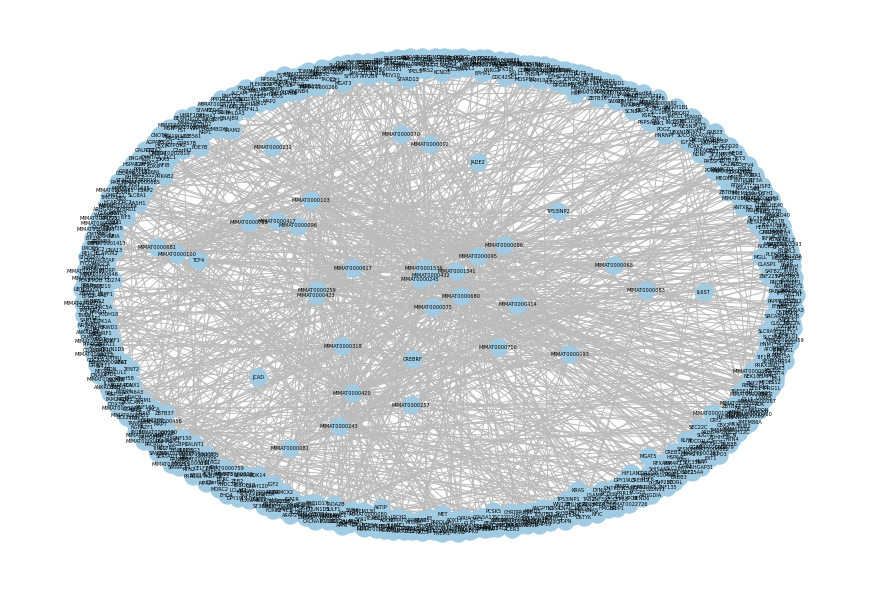

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# G = nx.Graph()
G = nx.from_pandas_edgelist(
    df=df_basal_like_pairs,
    source='accession_id',
    target='gene_name',
)

# nx.draw(G, with_labels=False)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=100)
nx.draw(G, pos,
        with_labels=True, 
        node_color='#A0CBE2', 
        edge_color='#BBBBBB',
        font_size=5,
        font_color='black')

plt.show()